## Week 10 Lab exercises

In this week we will continue investigating PDEs and study the wave equation, which is second order in time.

In [1]:
import numpy as np
from sympy import symbols, simplify, pprint, diff
from scipy.interpolate import lagrange
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# We will be working with this test function throughout the exercises:

def get_y_test_function(a_x_points) :
    y_test = np.exp(-a_x_points*a_x_points)
    return y_test

def get_dydx_test_function(a_x_points) :
    dydt_test = -2.0 * a_x_points * np.exp(-a_x_points*a_x_points)
    return dydt_test   

def get_d2ydx2_test_function(a_x_points) :
    d2ydt2_test = (4.0 * a_x_points * a_x_points * np.exp(-a_x_points*a_x_points)
                 - 2.0 * np.exp(-a_x_points*a_x_points))
    return d2ydt2_test 

### Pseudospectral derivatives from last week

The code below gives you the matrices for the first and second derivative of a function represented by N+1 points assuming an interval [-1,1].

_HINT - note the need to rescale the derivative according to the interval_

In [4]:
def get_pseudospectral_first_derivative_matrix(N) :
    
    indices = np.arange(N+1)
    u_i = np.cos(np.pi * indices / N)
    c_i = np.ones_like(indices)
    c_i[0] = 2.0
    c_i[N] = 2.0

    D_matrix = np.zeros([N+1,N+1])

    for idx_i in indices :
        for idx_j in indices :
            if(idx_i == 0 and idx_j == 0) : 
                D_matrix[idx_i,idx_j] = (2.0 * N * N + 1.0)/6.0
                
            elif (idx_i == N and idx_j == N) :
                D_matrix[idx_i,idx_j] = -(2.0 * N * N + 1.0)/6.0
                
            elif (idx_i == idx_j) :
                D_matrix[idx_i,idx_j] = - u_i[idx_i] / 2.0 / (1.0 - u_i[idx_i] * u_i[idx_i])
                
            else :
                D_matrix[idx_i,idx_j] = (c_i[idx_i] / c_i[idx_j] * (-1)**(idx_i+idx_j) 
                                         / (u_i[idx_i] - u_i[idx_j]))

    # Fix numerical errors when function flat         
    for idx_i in indices :
        D_matrix[idx_i,idx_i] = 0
        for idx_j in indices :
            if (idx_j != idx_i) : 
                D_matrix[idx_i,idx_i] += -D_matrix[idx_i,idx_j]                

    return D_matrix

def get_pseudospectral_second_derivative_matrix(N) :
    
    indices = np.arange(N+1)
    u_i = np.cos(np.pi * indices / N)
    c_i = np.ones_like(indices)
    c_i[0] = 2.0
    c_i[N] = 2.0

    D2_matrix = np.zeros([N+1,N+1])

    for idx_i in indices :
        for idx_j in indices :
            if((idx_i == idx_j) and (idx_i == 0 or idx_i == N)) : 
                D2_matrix[idx_i,idx_j] = (N ** 4.0 - 1.0) / 15.0
            
            elif ((idx_i == idx_j) and (idx_i != 0) and (idx_i != N)) :
                D2_matrix[idx_i,idx_j] = (- ((N*N - 1.0) * (1.0 - u_i[idx_i] * u_i[idx_i]) + 3.0) 
                                             / (3.0 * (1.0 - u_i[idx_i] * u_i[idx_i]) ** 2.0))
                 
            elif (idx_i == 0 and idx_j > 0) :
                D2_matrix[idx_i,idx_j] = ((2.0 / 3.0) * ((-1) ** idx_j) / c_i[idx_j] 
                                          * ((2.0 * N * N + 1.0) * (1.0 - u_i[idx_j]) - 6.0)
                                          / (1.0 - u_i[idx_j]) / (1.0 - u_i[idx_j]))
                
            elif (idx_i == N and idx_j < N) :
                D2_matrix[idx_i,idx_j] = ((2.0 / 3.0) * ((-1) ** (N+idx_j)) / c_i[idx_j] 
                                          * ((2.0 * N * N + 1.0) * (1.0 + u_i[idx_j]) - 6.0)
                                          / (1.0 + u_i[idx_j]) / (1.0 + u_i[idx_j]))
                
            else :
                D2_matrix[idx_i,idx_j] = (((-1) ** (idx_i+idx_j)) / c_i[idx_j] 
                                            * (u_i[idx_i]*u_i[idx_i] + u_i[idx_i]*u_i[idx_j] - 2.0)
                                            / (1.0 - u_i[idx_i]*u_i[idx_i]) / (u_i[idx_i] - u_i[idx_j])
                                            / (u_i[idx_i] - u_i[idx_j]))

    # Fix numerical errors when function flat            
    for idx_i in indices :
        D2_matrix[idx_i,idx_i] = 0
        for idx_j in indices :
            if (idx_j != idx_i) : 
                D2_matrix[idx_i,idx_i] += -D2_matrix[idx_i,idx_j]
                
    return D2_matrix

### Finite difference derivative matrices from last week

The code below gives you the 5 point finite derivative stencil matrices for the second derivative of a function represented by N+1 points assuming an interval [-1,1].

_HINT - note the need to rescale the derivative according to the interval_

In [7]:
def get_FD_second_derivative_matrix(a_N) :
    
    h = 2.0 / a_N
    one_over_h2 = 1.0 / (h*h)
    D2_matrix = np.zeros([a_N+1,a_N+1])

    indices = np.arange(a_N+1)
    for idx_i in indices :
        for idx_j in indices :
            if(idx_i == idx_j) :
                D2_matrix[idx_i,idx_j] = -30.0/12.0 * one_over_h2

            elif (idx_i == (idx_j+2)) :
                D2_matrix[idx_i,idx_j] = -1.0/12.0 * one_over_h2
                
            elif (idx_i == (idx_j+1)) :
                D2_matrix[idx_i,idx_j] = 16.0/12.0 * one_over_h2
                
            elif (idx_i == (idx_j-1)) :
                D2_matrix[idx_i,idx_j] = 16.0/12.0 * one_over_h2

            elif (idx_i == (idx_j-2)) :
                D2_matrix[idx_i,idx_j] = -1.0/12.0 * one_over_h2
                
            else :
                D2_matrix[idx_i,idx_j] = 0.0
                
    # Fix the ends with one sided derivatives
    D2_matrix[0,0] = 1.0 * one_over_h2
    D2_matrix[0,1] = -2.0 * one_over_h2
    D2_matrix[0,2] = 1.0 * one_over_h2
    D2_matrix[a_N,a_N] = 1.0 * one_over_h2
    D2_matrix[a_N,a_N-1] = -2.0 * one_over_h2
    D2_matrix[a_N,a_N-2] = 1.0 * one_over_h2
    
    return D2_matrix

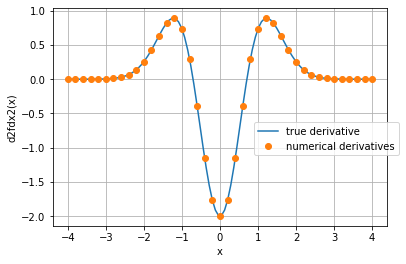

In [9]:
# Testing the second derivatives for pseudospectral method
N = 40
a = -4
b = 4

# Find the Gauss Lobato nodes
x_points = np.linspace(a,b,N+1)
y_points = get_y_test_function(x_points)

D2_matrix = get_FD_second_derivative_matrix(N)
# Rescale from interval [-1, 1] to [a, b]
d2ydx2 = 4.0/(b - a)/(b - a) * np.dot(D2_matrix, y_points)

# Plots
x_true = np.linspace(a,b,100)
plt.plot(x_true, get_d2ydx2_test_function(x_true), '-', label="true derivative")
plt.plot(x_points, d2ydx2, 'o', label="numerical derivatives")
plt.xlabel("x")
plt.ylabel("d2fdx2(x)")
plt.legend(bbox_to_anchor=(1.05, 0.5))
plt.grid();

### ACTIVITY 1 : Solving the wave equation using solve_ivp()
    
Here we will solve the wave equation using `solve_ivp()`, the midpoint method and the two derivative methods above.

The wave equation is:

$ \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} $

With $c$ a parameter for the speed that we can set to 0.5.

### Q1.1 Modify the heat equation code to solve the wave equation instead

Below is the HeatEquationPDE class from last week. Modify it to solve the wave equation instead. 

The key change is that now you will need to introduce a second dependent variable $v$ that represents the time derivative of $u$, in order to cast it as a first order problem. 

How is the solution different to the Heat equation for the same initial $u$ profile? You can set $v(x,t=0)=0$ initially.

The commands `np.array_split()` and `np.zeros_like()` can be useful for packing and unpacking the state vector.

In [10]:
# First make a class for the Heat Equation

class HeatEquationPDE :
    
    """
    Represents the Heat Equation equation PDE and its solution
    
    attributes: alpha (diffusivity), x_0, T_0 (an initial condition),
                N_grid (the size of the grid)
    
    """
    
    # constructor function
    def __init__(self, a_x, a_T0, a_max_time, method="finite_difference", a_alpha=0.5):
        self.alpha = a_alpha
        self.max_time = a_max_time
        self.x = a_x
        self.T0 = a_T0
        self.N_grid = np.size(a_x)            
        self._solution_t = []
        self._solution_y = []
        
        self.initial_value = self.T0
        
        if method == "finite_difference" :
            self.D2_matrix = get_FD_second_derivative_matrix(self.N_grid-1)
        elif method == "pseudospectral" :
            self.D2_matrix = get_pseudospectral_second_derivative_matrix(self.N_grid-1)
        else :
            assert False, "Requested derivative method not implemented"
            
        # Rescale for the derivative matrix for the interval we are looking at
        b_minus_a = self.x[self.N_grid-1] - self.x[0]
        self.D2_matrix *= 4.0 / b_minus_a / b_minus_a

    def calculate_dydt(self, t, current_state) :
        
        # Just for readability
        dTdt = np.zeros_like(current_state)
        
        # Now actually work out the time derivatives
        dTdt[:] =  self.alpha * np.dot(self.D2_matrix, current_state)
           
        # Zero the derivatives at the end for stability 
        # (especially important in the pseudospectral method)
        dTdt[0] = 0.0
        dTdt[1] = 0.0
        dTdt[self.N_grid-1] = 0.0
        dTdt[self.N_grid-2] = 0.0
        
        return dTdt       
 
    def integrate_using_solve_ivp(self) :
        
        t_solution = np.linspace(0.0, self.max_time, 100)
        solution = solve_ivp(self.calculate_dydt, [0, self.max_time],
                        self.initial_value, t_eval=t_solution)
        
        self._solution_t = solution.t
        self._solution_y = solution.y
        
        self._solution_solved = True
        
        return solution.t, solution.y

In [77]:
# Your code here..

# First make a class for the Wave Equation

class WaveEquationPDE :
    
    """
    Represents the Wave Equation equation PDE and its solution
    
    attributes: c (speed), x_0, T_0 (an initial condition),
                N_grid (the size of the grid)
    
    """
    
    # constructor function
    def __init__(self, a_x, a_y0, a_max_time, a_CFL=1.0, a_method="finite_difference", a_c=0.5):
        self.c = a_c
        self.CFL = a_CFL
        self.max_time = a_max_time
        self.x = a_x
        self.y0 = a_y0
        self.N_grid = np.size(a_x)            
        self._solution_t = []
        self._solution_y = []
        self.method = a_method
        
        self.initial_value = self.y0
        
        if self.method == "finite_difference" :
            self.D2_matrix = get_FD_second_derivative_matrix(self.N_grid-1)
        elif self.method == "pseudospectral" :
            self.D2_matrix = get_pseudospectral_second_derivative_matrix(self.N_grid-1)
        else :
            assert False, "Requested derivative method not implemented"
            
        # Rescale for the derivative matrix for the interval we are looking at
        b_minus_a = self.x[self.N_grid-1] - self.x[0]
        self.D2_matrix *= 4.0 / b_minus_a / b_minus_a

    def calculate_dydt(self, t, current_state) :
        
        # Just for readability
        [u,v] = np.array_split(current_state, 2)
        dydt = np.zeros_like(current_state)
        dudt, dvdt = np.array_split(dydt, 2)
        
        # Now actually work out the time derivatives
        # Note that we want to fill the dudt and dvdt we created
        # above and not overwrite them (try removing the colon to see
        # what happens)
        dudt[:] =  v
        dvdt[:] =  self.c * self.c * np.dot(self.D2_matrix, u)
           
        # Zero the derivatives at the end for stability 
        # (especially important in the pseudospectral method)
        # Now need to do it for v and u
        dydt[0] = 0.0
        dydt[1] = 0.0
        dydt[self.N_grid-1] = 0.0
        dydt[self.N_grid-2] = 0.0
        dydt[self.N_grid] = 0.0
        dydt[self.N_grid+1] = 0.0
        dydt[self.N_grid*2-1] = 0.0
        dydt[self.N_grid*2-2] = 0.0
        
        return dydt      
 
    def integrate_using_solve_ivp(self) :
        
        t_solution = np.linspace(0.0, self.max_time, 100)
        solution = solve_ivp(self.calculate_dydt, [0, self.max_time],
                        self.initial_value, t_eval=t_solution)
        
        self._solution_t = solution.t
        self._solution_y = solution.y
        
        self._solution_solved = True
        
        return solution.t, solution.y
    
    def integrate_using_midpoint(self) :
        
        assert self.method == "finite_difference", 'need to use FDs'
        dx = self.x[1] - self.x[0] # assume constant using FDs
        
        # Using half the CFL condition in practise just to be sure it is stable
        delta_t = self.CFL * dx
        num_timesteps = int(self.max_time / delta_t) + 1
        t_solution = np.linspace(0.0, self.max_time, num_timesteps)
        y_solution = np.zeros([2*self.N_grid, num_timesteps])
        
        for itime, time in enumerate(t_solution) :
            if itime == 0 :
                y_solution[:, itime] = self.initial_value
                old_time = time
            else :
                dydt_at_t = self.calculate_dydt(old_time, y_solution[:, itime-1])
                
                # Take half step
                y_t_plus_half = y_solution[:, itime-1] + 0.5 * dydt_at_t * delta_t
                t_plus_half = old_time + 0.5 * delta_t
                dydt_at_t_plus_half = self.calculate_dydt(t_plus_half, y_t_plus_half)
                
                # Take full step
                y_solution[:, itime] = (y_solution[:, itime-1] + dydt_at_t_plus_half * delta_t) 
                old_time = time 

        self._solution_t = t_solution
        self._solution_y = y_solution
        
        return t_solution, y_solution

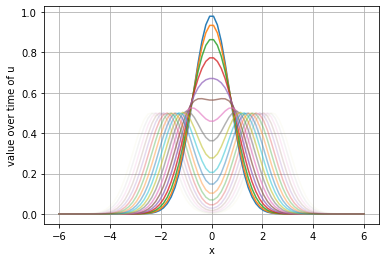

In [78]:
# Test the solution
num_points = 80
a=-6
b=6
x_values = np.linspace(a , b,  num_points)
u0 = get_y_test_function(x_values)
v0 = np.zeros_like(u0)
y0 = np.concatenate([u0,v0])
max_time = 5.0

my_wave_equation = WaveEquationPDE(x_values, y0, max_time)
t_solution, y_solution = my_wave_equation.integrate_using_solve_ivp()

u_solution = y_solution[0:num_points,:]

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 5 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = u_solution[:,i]
        plt.plot(x_values, f_t, label=labelt, alpha=(1-t_i/max_time))

plt.xlabel('x')
plt.ylabel('value over time of u')
plt.grid()

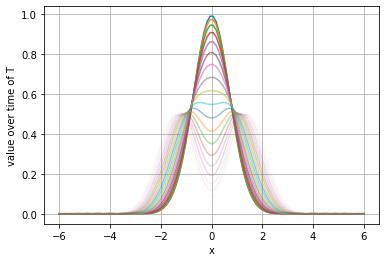

In [79]:
# Now test using pseudospectral FDs

num_points = 28
a = -6
b = 6

u_i = np.cos(np.pi * np.arange(num_points+1) / num_points)
x_values = (b - a)/2.0 * u_i + (a + b)/2.0
u0 = get_y_test_function(x_values)
v0 = np.zeros_like(u0)
y0 = np.concatenate([u0,v0])
max_time = 2.0

my_wave_equation = WaveEquationPDE(x_values, y0, max_time, "pseudospectral")
t_solution, y_solution = my_wave_equation.integrate_using_solve_ivp()
u_solution = y_solution[0:num_points+1,:]

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 5 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = u_solution[:,i]
        
        # Just to make the plot nice use the points to reconstruct the fitting function
        lagrange_polynomial = lagrange(x_values, f_t)
        x_lagrange = np.linspace(a, b, 100)
        plt.plot(x_lagrange, lagrange_polynomial(x_lagrange), '-', 
                 label=labelt, alpha=(1-t_i/max_time))

plt.xlabel('x')
plt.ylabel('value over time of T')
plt.grid()

### Q1.2 Implement the RK2 integration method and test the CFL condition

Implement a midpoint method to integrate in place of `solve_ivp()` so that you can control the size of the time steps. Use finite difference stencils for the spatial derivatives.

The CFL condition for this method is $\Delta t = \lambda \Delta x$ with $\lambda \sim 1/c$. 

Add a parameter to set the CFL condition, and find the exact value at which this breaks down by trial and error. Check it for other values of the speed $c$.

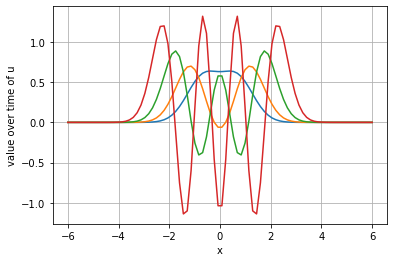

In [108]:
# Your code here...

# Test the solution
num_points = 80
a=-6
b=6
x_values = np.linspace(a , b,  num_points)
u0 = get_y_test_function(x_values)
v0 = np.zeros_like(u0)
y0 = np.concatenate([u0,v0])
max_time = 6.0
c = 0.5

CFL = 4.0/c #Breaks down very close to expected value
my_wave_equation = WaveEquationPDE(x_values, y0, max_time, CFL,
                                   "finite_difference", c)
t_solution, y_solution = my_wave_equation.integrate_using_midpoint()

u_solution = y_solution[0:num_points,:]

for i, t_i in enumerate(t_solution) :
    if (i > 0) and (i % 1 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = u_solution[:,i]
        plt.plot(x_values, f_t, label=labelt)

plt.xlabel('x')
plt.ylabel('value over time of u')
plt.grid()